In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import MyFuncs
import numpy as np
import scipy
import scipy.stats 
from copy import copy

In [2]:
class Clusters:  # The cluster groups should not include anything more than the groups (no names)
    def __init__(self, path, group_split="\n", gene_split="\t", taxa_split="-", global_taxa_count=None):
        with open(path, "r") as _ifile:
            self.input = _ifile.read()

        clusters = self.input.strip().split(group_split)
        self.clusters = [Cluster([y for y in x.strip().split(gene_split)], global_taxa_count=global_taxa_count)
                         for x in clusters]
        self.size = 0.
        for group in self.clusters:
            self.size += group.len

        self.printer = MyFuncs.DynamicPrint()
        self.taxa_split = taxa_split

    def score_all_clusters(self):
        score = 0
        taxa = pd.Series()
        for cluster in self.clusters:
            # Weight each score by cluster size. Final score max = 1.0, min = 0.0
            score += cluster.score() * (cluster.len / self.size)
            temp_taxa = [x.split(self.taxa_split)[0] for x in cluster.cluster]
            temp_taxa = pd.Series(temp_taxa)
            taxa = pd.concat([taxa, temp_taxa])

        return self.srs(score)

    def write(self, outfile):
        with open(outfile, "w") as _ofile:
            for cluster in self.clusters:
                _ofile.write("%s\n" % "\t".join(cluster.cluster))
        return

    # The following are possible score modifier schemes to account for group size
    def gpt(self, score, taxa):  # groups per taxa
        genes_per_taxa = self.size / len(taxa.value_counts())
        num_clusters_modifier = abs(genes_per_taxa - len(self.clusters))
        score = round(score / len(self.clusters) - num_clusters_modifier ** 1.2, 2)
        return score

    def srs(self, score):  # Square root sequences
        # print(len(self.clusters))
        modifier = abs(self.size ** 0.5 - len(self.clusters)) ** 1.2
        score = round(score / len(self.clusters) - modifier, 2)
        return score


In [3]:

class Cluster:
    def __init__(self, cluster, taxa_split="-", global_taxa_count=None):
        cluster.sort()
        self.cluster = cluster
        self.len = len(self.cluster)
        self.name = ""
        self.taxa_split = taxa_split
        self.global_taxa_count = global_taxa_count

    def score(self):
        taxa = [x.split(self.taxa_split)[0] for x in self.cluster]
        taxa = pd.Series(taxa)

        if len(taxa) == 1:
            return 0

        score = 0
        try:
            for taxon, num in taxa.value_counts().iteritems():
                if num == 1:
                    score += self.global_taxa_count[taxon] ** 0.5

                else:
                    score -= (1 / self.global_taxa_count[taxon] ** 0.5) * num * 2

        except TypeError:  # This happens if global_taxa_count is not set
            singles = 0
            for taxon, num in taxa.value_counts().iteritems():
                if num == 1:
                    singles += 1

                else:
                    score -= num

            score += singles ** 2

        return score

    def compare(self, query):
        matches = set(self.cluster).intersection(query.cluster)
        weighted_match = (len(matches) * 2.) / (self.len + query.len)
        print("name: %s, matches: %s, weighted_match: %s" % (self.name, len(matches), weighted_match))
        return weighted_match

    def __str__(self):
        return str(self.cluster)

In [4]:
def split_all_by_all(data_frame, remove_list):
    if len(data_frame.columns) != 3:
        raise AttributeError("dataframe should be 3 columns")

    data_frame = copy(data_frame)
    columns = data_frame.columns
    data_frame.columns = [0, 1, 2]

    removed = data_frame.loc[data_frame[0].isin(remove_list)]
    removed = removed.loc[removed[1].isin(remove_list)]

    remaining = data_frame.loc[~data_frame[0].isin(remove_list)]
    remaining = remaining.loc[~remaining[1].isin(remove_list)]

    remaining.columns = columns
    removed.columns = columns
    return {"remaining": remaining, "removed": removed}

In [5]:
def clique_checker(cluster, df_all_by_all, taxa_split="-"):
    valve = MyFuncs.SafetyValve(50)
    genes = pd.DataFrame([x.split(taxa_split) for x in cluster.cluster])
    genes.columns = ["taxa", "gene"]
    
    duplicates = []
    in_dict = {}
    cliques = []
    
    # pull out all genes with replicate taxa
    for taxa, num in genes['taxa'].value_counts().iteritems():
        if num > 1:
            taxa = genes.loc[genes["taxa"] == taxa]
            for i, rec in taxa.iterrows():
                gene = "%s-%s" % (rec["taxa"], rec["gene"])
                duplicates.append(gene)
    
    #print(duplicates)
    
    # Find best hits for all duplicate genes
    def get_best_hit(_gene):
        _best_hit = df_all_by_all[(df_all_by_all[0] == _gene) | (df_all_by_all[1] == _gene)]
        _best_hit.columns = ["subj", "query", "score"]
        _best_hit = _best_hit.loc[_best_hit["score"] == max(_best_hit["score"])].values[0]
        return _best_hit
        
    for gene in duplicates:
        best_hit = get_best_hit(gene)
        in_dict[gene] = (best_hit[0], best_hit[2]) if best_hit[1] == gene else (best_hit[1], best_hit[2])
    
    # pp.pprint(in_dict)
    # Iterate through in_dict and pull in all genes to fill out all best-hit sub-graphs from duplicates    
    in_dict_length = len(in_dict)
    while True:
        copy_in_dict = copy(in_dict)
        valve.step()
        for indx, value in copy_in_dict.items():
            if value[0] not in in_dict:
                best_hit = get_best_hit(value[0])
                in_dict[value[0]] = (best_hit[0], best_hit[2]) if best_hit[1] == value[0] else (best_hit[1], best_hit[2])
 
        if in_dict_length == len(in_dict):
            break
        else:
            in_dict_length = len(in_dict)
    
    # Separate all sub-graphs (i.e., cliques) into lists
    # pp.pprint(in_dict) 
    while len(in_dict):
        valve.step()
        copy_in_dict = copy(in_dict)
        for indx, value in copy_in_dict.items():
            in_clique = False
            
            for i, clique in enumerate(cliques):
                if indx in clique or value[0] in clique:
                    if type(in_clique) != int:
                        # print("1: %s-%s" % (indx, value[0]))
                        in_clique = i
                        cliques[i] = list({indx, value[0]}.union(set(cliques[i])))
                        del in_dict[indx]
                        # print(cliques)
                    
                    else:
                        # print("2: %s-%s" % (indx, value[0]))
                        cliques[in_clique] = list(set(cliques[in_clique]).union(set(cliques[i])))
                        del cliques[i]
                        # print(cliques)
                        break
            
            if type(in_clique) != int:
                # print("3: %s-%s" % (indx, value[0]))
                del in_dict[indx]
                cliques.append([indx, value[0]])
                # print(cliques)
    
    # strip out any 'cliques' that contain less than 3 genes
    while True:
        valve.step()
        for i, clique in enumerate(cliques):
            if len(clique) < 3:
                del cliques[i]
                break
        break
    
    if not cliques or cliques[0] == "":
        print("No potental cliques detected")
        return
    
    print("Possible cliques\n%s" % cliques)
    final_cliques = []
    fig, ax = plt.subplots(1, len(cliques))
    
    for i, clique in enumerate(cliques):
        total_scores = pd.DataFrame()
        if len(clique) < 3:
            continue
        
        for gene in clique:
            scores = df_all_by_all[df_all_by_all[0] == gene]
            scores = scores[scores[1].isin(cluster.cluster)]
            tmp = df_all_by_all[df_all_by_all[1] == gene]
            tmp = tmp[tmp[0].isin(cluster.cluster)]
            scores = pd.concat([scores, tmp])
            total_scores = total_scores.append(scores)
        
        clique_scores = total_scores[(total_scores[0].isin(clique)) & (total_scores[1].isin(clique))]
        total_scores = total_scores.drop(clique_scores.index.values)
        total_kde = scipy.stats.gaussian_kde(total_scores[2], bw_method='silverman')
        
        x_grid = np.linspace(0.0, 1.2, 1000)
        
        fig.subplots_adjust(wspace=0)
        
        pdf = total_kde.evaluate(x_grid)
        if len(cliques) > 1:
            ax[i].plot(x_grid, pdf, color='blue', alpha=0.5, lw=3)

            clique_kde = scipy.stats.gaussian_kde(clique_scores[2], bw_method='silverman')
            pdf = clique_kde.evaluate(x_grid)
            ax[i].plot(x_grid, pdf, color='red', alpha=0.5, lw=3)

            ax[i].set_xlim(0.0, 1.2)
        else:
            ax.plot(x_grid, pdf, color='blue', alpha=0.5, lw=3)

            clique_kde = scipy.stats.gaussian_kde(clique_scores[2], bw_method='silverman')
            pdf = clique_kde.evaluate(x_grid)
            ax.plot(x_grid, pdf, color='red', alpha=0.5, lw=3)

            ax.set_xlim(0.0, 1.2)
        
        total_resample = total_kde.resample(10000)
        total95 = [scipy.stats.scoreatpercentile(total_resample, 2.5), scipy.stats.scoreatpercentile(total_resample, 97.5)]
        
        clique_resample = clique_kde.resample(10000)
        clique95 = [scipy.stats.scoreatpercentile(clique_resample, 2.5), scipy.stats.scoreatpercentile(clique_resample, 97.5)]
        integrated = total_kde.integrate_box_1d(clique95[0], clique95[1])
        
        print("")
        print("total: %s - %s" % (total95[0], total95[1]))
        print("clique: %s - %s" % (clique95[0], clique95[1]))
        print(integrated)
        
        if integrated < 0.05:
            final_cliques.append(clique)
    
    fig.savefig("data_files/kde.svg")
    if not final_cliques:
        print("\nCliques not significantly supported")
        return
    return final_cliques

In [6]:
scores_data = pd.read_csv("data_files/Ctenos_final_scores.csv", "\t", header=None)
scores_data.columns = [0, 1, 2]
final_clusters = Clusters("data_files/groups.txt")

Possible cliques
[['Cfu-PanxαD', 'Bab-PanxαC', 'Bfr-PanxαB', 'Tin-PanxαF', 'Lcr-PanxαC'], ['Cfu-PanxαF', 'Cfu-PanxαA', 'Cfu-PanxαB', 'Edu-PanxαF']]

total: 0.543437374377 - 1.04534410948
clique: 0.507632930353 - 1.11268224482
0.9884578023

total: 0.510484392641 - 0.987294033907
clique: 0.471458009078 - 0.99242316925
0.972897521798

Cliques not significantly supported

None


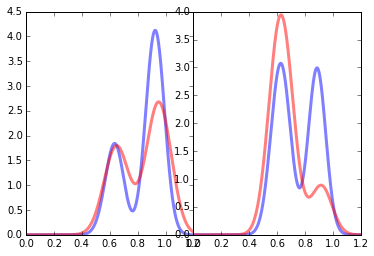

In [7]:
print("\n%s" % clique_checker(final_clusters.clusters[0], scores_data))

Possible cliques
[['Bfo-PanxαF', 'Hca-PanxαD', 'Mle-Panxα6'], ['Mle-Panxα12', 'Hca-PanxαH', 'Vpa-PanxαG', 'Bfo-PanxαD', 'Bch-PanxαE', 'Tin-PanxαE', 'Lcr-PanxαJ']]

total: 0.671194885842 - 0.709392504343
clique: 0.762252897724 - 0.948781503171
0.0

total: 0.632578123454 - 1.02448870038
clique: 0.897625950876 - 0.978578538884
0.437149875933


[['Bfo-PanxαF', 'Hca-PanxαD', 'Mle-Panxα6']]

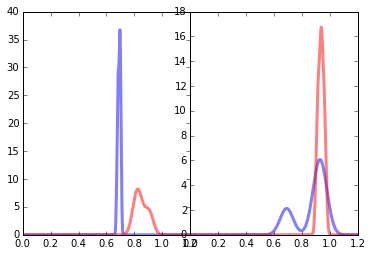

In [8]:
clique_checker(final_clusters.clusters[1], scores_data)

Possible cliques
[['Mle-Panxα10', 'Mle-Panxα9', 'Vpa-PanxαB']]

total: 0.657460784899 - 1.0166258136
clique: 0.82374545494 - 1.03391555709
0.720042338324

Cliques not significantly supported


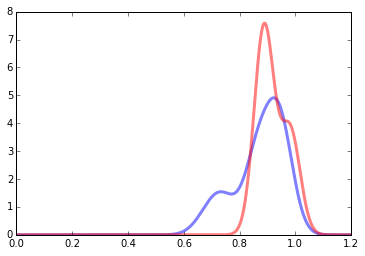

In [9]:
clique_checker(final_clusters.clusters[2], scores_data)